This file plots out graphs from the Corum results in 03_PlotElasticNetCoefficients.ipynb

We are producitn networks with transcript to protein relationship if the Elastic Net coefficient
of a transcript for a protein is > 0.05. Only proteins with improved correlation coefficient > 0.2 are included.


In [46]:
feature_todo = 'string'
# only proteins are included if the feature-included test set r is greater than the self-feature r by this much
included_protein_threshold = 0.25
min_nodes = 2  # only plot subgraphs if there are as many nodes
# only transcripts with this much coef contribution or feature_importance will be included in the graphs
# 0.05 coef 0.05 feature importance for corum; 0.1 coef 0.01 feature importance for string
min_coef = 0.1
min_feature_importance = 0.05
file_dir = f'03_ExportFeatureCoefficients_Output/res2_{feature_todo}_{included_protein_threshold}_out3_coefs' # "notebook/res2_stringhi_0.2_coefs"  # path to the coef text fileset
output_dir = f'05_PlotCorumNetworks_Output/{feature_todo}_weakly_connected_{min_coef}coef_{min_feature_importance}feat_out3'  # 'notebook/05_PlotCorumNetworks_Output/stringhi'  # path to output directory

In [47]:
import pandas as pd
import os
import re
import numpy as np
import networkx as nx
from pyvis.network import Network

os.makedirs(output_dir, exist_ok=True)

def visualize(G, SG, output_filename='graph.html', show_buttons=False, only_physics_buttons=False):

    N = Network(height='100%', width='100%', font_color='black', directed=True)
    # N = nx.Graph()
    # uncomment the following if the graph is large
    # N.barnes_hut(spring_strength=0.006)
    #color_map = []

    for n in G.nodes():
        # if n in SG:
        #     color_map.append('royalblue')
        # else:
        #     color_map.append('orange')
        if n in SG:  # if the node is part of the sub-graph
            color = 'royalblue'
        else:
            color = 'orange'
        N.add_node(n, label=n, color=color)

    #weight_map=[]
    #style_map=[]
    for e in G.edges():
        u=e[0]
        v=e[1]
        N.add_edge(u, v,
                   title=np.round(G[u][v]['Coef'], 3),
                   width=G[u][v]['Weight'] * 5,
                   color='orange' if G[u][v]['Coef'] > 0 else 'lightgray',
                   )
        #weight_map.append(G[u][v]['Weight'])
        #style_map.append('red' if G[u][v]['Coef'] > 0 else 'blue')

    # plt.figure(figsize=(12,12))
    # nx.draw_networkx(N, node_color=color_map, width=weight_map, edge_color=style_map)
    # plt.savefig(f'{output_filename}.png')
    # plt.cla()

    if show_buttons:
            if only_physics_buttons:
                N.show_buttons(filter_=['physics'])
            else:
                N.show_buttons()

    return N.show(f'{output_filename}.html')

In [48]:
en_files = [f for f in os.listdir(file_dir) if re.match('.*_ElasticNet.csv', f)]
en_dfs = []
for file in en_files:
    df = pd.read_csv(os.path.join(file_dir, file))
    df['Protein'] = re.sub('_.*$', '', file)
    en_dfs.append(df)

en_merged = pd.concat(en_dfs)
en_merged['Transcript'] = en_merged['Transcript'].str.replace('_transcriptomics', '')


rf_files = [f for f in os.listdir(file_dir) if re.match('.*_RandomForest.csv', f)]
rf_dfs = []
for file in rf_files:
    df = pd.read_csv(os.path.join(file_dir, file))
    df['Protein'] = re.sub('_.*$', '', file)
    rf_dfs.append(df)

rf_merged = pd.concat(rf_dfs)
rf_merged['Transcript'] = rf_merged['Transcript'].str.replace('_transcriptomics', '')

In [49]:
result = pd.merge(en_merged, rf_merged, how="outer", on=['Protein', 'Transcript']).copy()
result = result.fillna(0)
result = result[(abs(result['Coef']) >= min_coef) | (result['Feature_Importance'] >= min_feature_importance)]
# result['Feature_Importance_Rank'] = result.groupby('Protein')['Feature_Importance'].rank(method='dense', ascending=True)
result['Feature_Importance_Percentile'] = result.groupby('Protein')['Feature_Importance'].rank(method='min', ascending=True, pct=True)
result['Clipped_Coef']= np.clip(result['Coef'], -1, 1)
result["Weight"] = abs(result['Clipped_Coef']) + result['Feature_Importance_Percentile'] # + result['rank']/10

In [50]:
result
result.to_csv(f'05_PlotCorumNetworks_Output/degrees/{feature_todo}_weakly_connected_{min_coef}coef_{min_feature_importance}feat_edgelist.csv')  # 'notebook/05_PlotCorumNetworks_Output/stringhi'  # path to output directory

In [51]:

Giant = nx.from_pandas_edgelist(result,
                                source='Transcript',
                                target='Protein',
                                edge_attr=True,
                                create_using=nx.DiGraph(),  # Cannot use directed graph for connected subgraph
                                )


# In the newer versions of NetworkX this is the recommended method of getting connected subgraphs
graphs = list(Giant.subgraph(c).copy() for c in nx.weakly_connected_components(Giant))


# Loop through subgraphs and export
for i, g in enumerate(graphs):

    # Skip if there are fewer than 3 nodes
    if g.number_of_nodes() < min_nodes:
        continue

    # Make subgraph into data frame
    g_df = nx.convert_matrix.to_pandas_edgelist(g)

    # Get protein nodes
    proteins = g_df.iloc[:,1].tolist()

    # Get the hub gene using nx.pagerank
    ec = nx.in_degree_centrality(g)
    hub_protein = pd.Series(ec, index=ec.keys()).sort_values(ascending=False).index[0]

    # Plot function
    visualize(g , proteins,
              output_filename=os.path.join(output_dir, f'{str(i)}_{hub_protein}'),
              show_buttons=True,
              only_physics_buttons=True)

    # Write out data frame
    g_df.to_csv(os.path.join(output_dir, f'{str(i)}_{hub_protein}.csv'), index=False)

In [52]:
import matplotlib.pyplot as plt
for i, g in enumerate(graphs):
    print(g.number_of_nodes())

9099
2
1
2
2
2
2
2
4
1
3
2
2
2
2
2
2
1
3
4
1
2
3
3
2
2
1
2
3
3
2
1
2
2
2
3
3
1
1
2
2
1
2
1
2
2
2
2
1
1
2
2
1
2


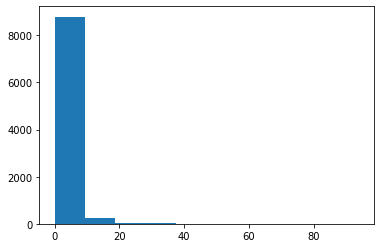

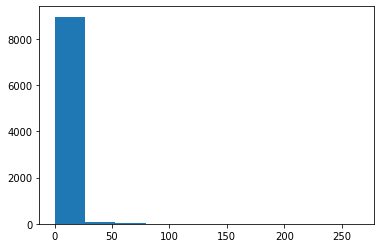

In [53]:
def plot_outdegree_dist(G):
    degrees = [G.out_degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

def plot_indegree_dist(G):
    degrees = [G.in_degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_outdegree_dist(graphs[0])
plot_indegree_dist(graphs[0])

In [54]:
summary_out =  f'05_PlotCorumNetworks_Output/degrees/{feature_todo}_weakly_connected_{min_coef}coef_{min_feature_importance}feat_out3'  # 'notebook/05_PlotCorumNetworks_Output/stringhi'  # path to output directory

pd.DataFrame([(n, graphs[0].out_degree(n)) for n in graphs[0].nodes()]).to_csv(f'{summary_out}_graph0_outdegree.csv', index=False)
pd.DataFrame([(n, graphs[0].in_degree(n)) for n in graphs[0].nodes()]).to_csv(f'{summary_out}_graph0_indegree.csv', index=False)

pd.DataFrame([(n, graphs[1].out_degree(n)) for n in graphs[1].nodes()]).to_csv(f'{summary_out}_graph1_outdegree.csv', index=False)
pd.DataFrame([(n, graphs[1].in_degree(n)) for n in graphs[1].nodes()]).to_csv(f'{summary_out}_graph1_indegree.csv', index=False)